#INSTALLATION AND IMPORTS

In [26]:
# GPU allowance
!pip install tensorflow-gpu
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import tifffile as tif

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import visualkeras 

import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.utils import plot_model, to_categorical
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


# About dataset
* change the path according to where you will put the dataset folder.
* please avoid changing any name
* contact me to explain you how to use the dataset or just figure it out by your self
* just remove the drive mount if you dont wanna run the code on collab and store your data in drive, its still doable on your desktop while keeping 
path='drive/MyDrive/Data/'

In [28]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# This path is the path to the folder Data, it could be changed if you change the location of the data set folder `Data` #
path='drive/MyDrive/Data/'


Mounted at /content/drive/


**Add as much classes followed by same ammount of if/elif state to fetch the data into corresponding arrays**

In [30]:
class_names = []
# classes #
class_A, class_B, class_C = [],[],[]

# standarazing shapes #
width, height = 180, 800


# getting the names of the classes #
for folder_name in os.listdir(path):
  if folder_name.startswith('Class'):
    class_names.append(folder_name)

# putting every FHistBanner inside the corresponding class array #
for class_name in (class_names):
  for fhist_banner in tqdm_notebook(os.listdir(path + '/' +class_name)):
    fh = tif.imread(path + '/' +class_name + '/' + fhist_banner)

    # resize the FHistBanner since they dont have the same size #
    fh = cv2.resize(fh,(height,width))

    # check in which class the FHistBanner image is associated to #            
    if class_name.endswith('A'):
      class_A.append(fh)
    elif class_name.endswith('B'):
      class_B.append(fh)
    elif class_name.endswith('C'):
      class_C.append(fh)    
  print(class_name, ' Loaded.')

# convert the arrays to np.arrays #
class_A, class_B, class_C = np.array(class_A), np.array(class_B), np.array(class_C)

<ipython-input-30-43b1375e6791>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fhist_banner in tqdm_notebook(os.listdir(path + '/' +class_name)):


  0%|          | 0/41 [00:00<?, ?it/s]

Class_A  Loaded.


  0%|          | 0/41 [00:00<?, ?it/s]

Class_C  Loaded.


  0%|          | 0/38 [00:00<?, ?it/s]

Class_B  Loaded.


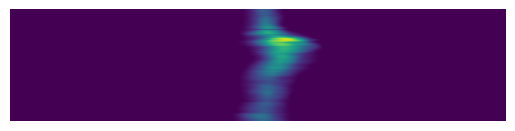

In [31]:
# plot a random sample of a Force banner from the class A
x = random.randint(0, len(class_C)-1)
plt.imshow(class_C[x])
plt.axis('off')
plt.savefig('plot.png',bbox_inches='tight', pad_inches=0)
plt.show()

**make sure here to add as much name classes multiplyed by the number of its FHistBanner associated**

In [9]:
# making a data frame for the labels #
df = pd.DataFrame({'Labels': ['Class_A']*len(class_A) + ['Class_B']*len(class_B) + ['Class_C']*len(class_C)})

# encoding the labels #
mapping = {val: i for i, val in enumerate(df['Labels'].unique())}
df['encoded_Labels'] = df['Labels'].apply(lambda x: mapping[x])

labels = df['encoded_Labels']

# display every calss along with its encoded label #
# this is useful for the next cell #
unique_df = df.drop_duplicates().reset_index(drop=True)
unique_df

,Labels,encoded_Labels
0,Class_A,0
1,Class_B,1
2,Class_C,2


**We homogeneously and consistently split the data into training 80%, 10% validation and 10% for test**

add as much lines as needed depending on how many classes you have... i will assume you learned that so am not going to remind you again anymore from now on.

Actually one useful reminder, dont forget to change for every class bellows the associated encoded label inside the `train_test_split` function.

NOTE: you can find the encoded assocciation from the display above.and keep in mind, always follow the same order

In [10]:
# Split data into train and test sets #
X_train_val_A, X_test_A, y_train_val_A, y_test_A = train_test_split(class_A, labels[labels==0], test_size=0.1, random_state=42)
X_train_val_B, X_test_B, y_train_val_B, y_test_B = train_test_split(class_B, labels[labels==1], test_size=0.1, random_state=42)
X_train_val_C, X_test_C, y_train_val_C, y_test_C = train_test_split(class_C, labels[labels==2], test_size=0.1, random_state=42)

# Split train data into train and validation sets #
X_train_A, X_valid_A, y_train_A, y_valid_A = train_test_split(X_train_val_A, y_train_val_A, test_size=0.1, random_state=42)
X_train_B, X_valid_B, y_train_B, y_valid_B = train_test_split(X_train_val_B, y_train_val_B, test_size=0.1, random_state=42)
X_train_C, X_valid_C, y_train_C, y_valid_C = train_test_split(X_train_val_C, y_train_val_C, test_size=0.1, random_state=42)

X_train = np.concatenate((X_train_A, X_train_B, X_train_C))
X_valid = np.concatenate((X_valid_A, X_valid_B, X_valid_C))
X_test = np.concatenate((X_test_A, X_test_B, X_test_C))

y_train = pd.concat([y_train_A, y_train_B, y_train_C])
y_valid = pd.concat([y_valid_A, y_valid_B, y_valid_C])
y_test = pd.concat([y_test_A, y_test_B, y_test_C])

#MODEL TRAINING
* CNN

In [11]:
def get_cnn(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the CNN Model"""
    x = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same')(x)
    x = Flatten() (x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='softmax')(x)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
input_img = Input((width, height,1))

model = get_cnn(input_img, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 800, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 800, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 800, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 400, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 400, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 400, 64)       36928     
                                                             

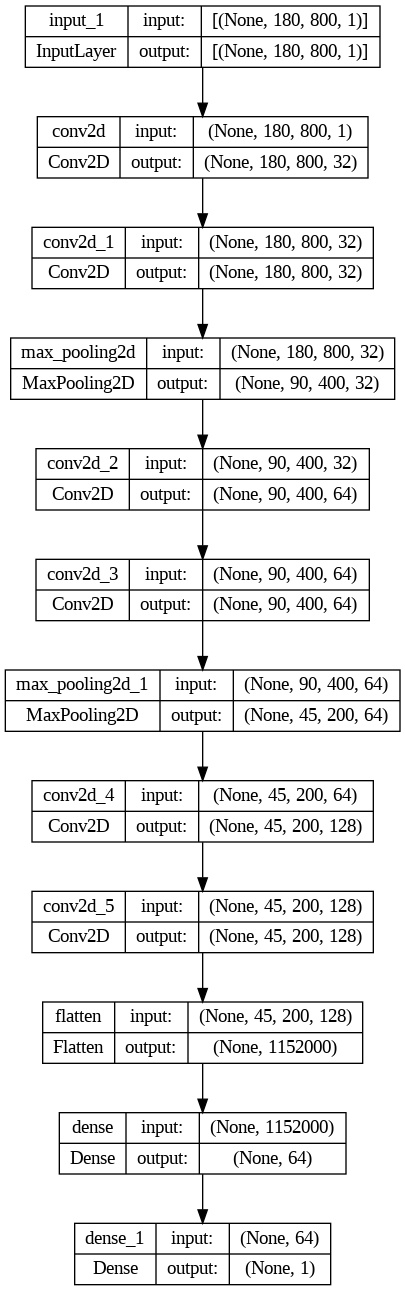

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

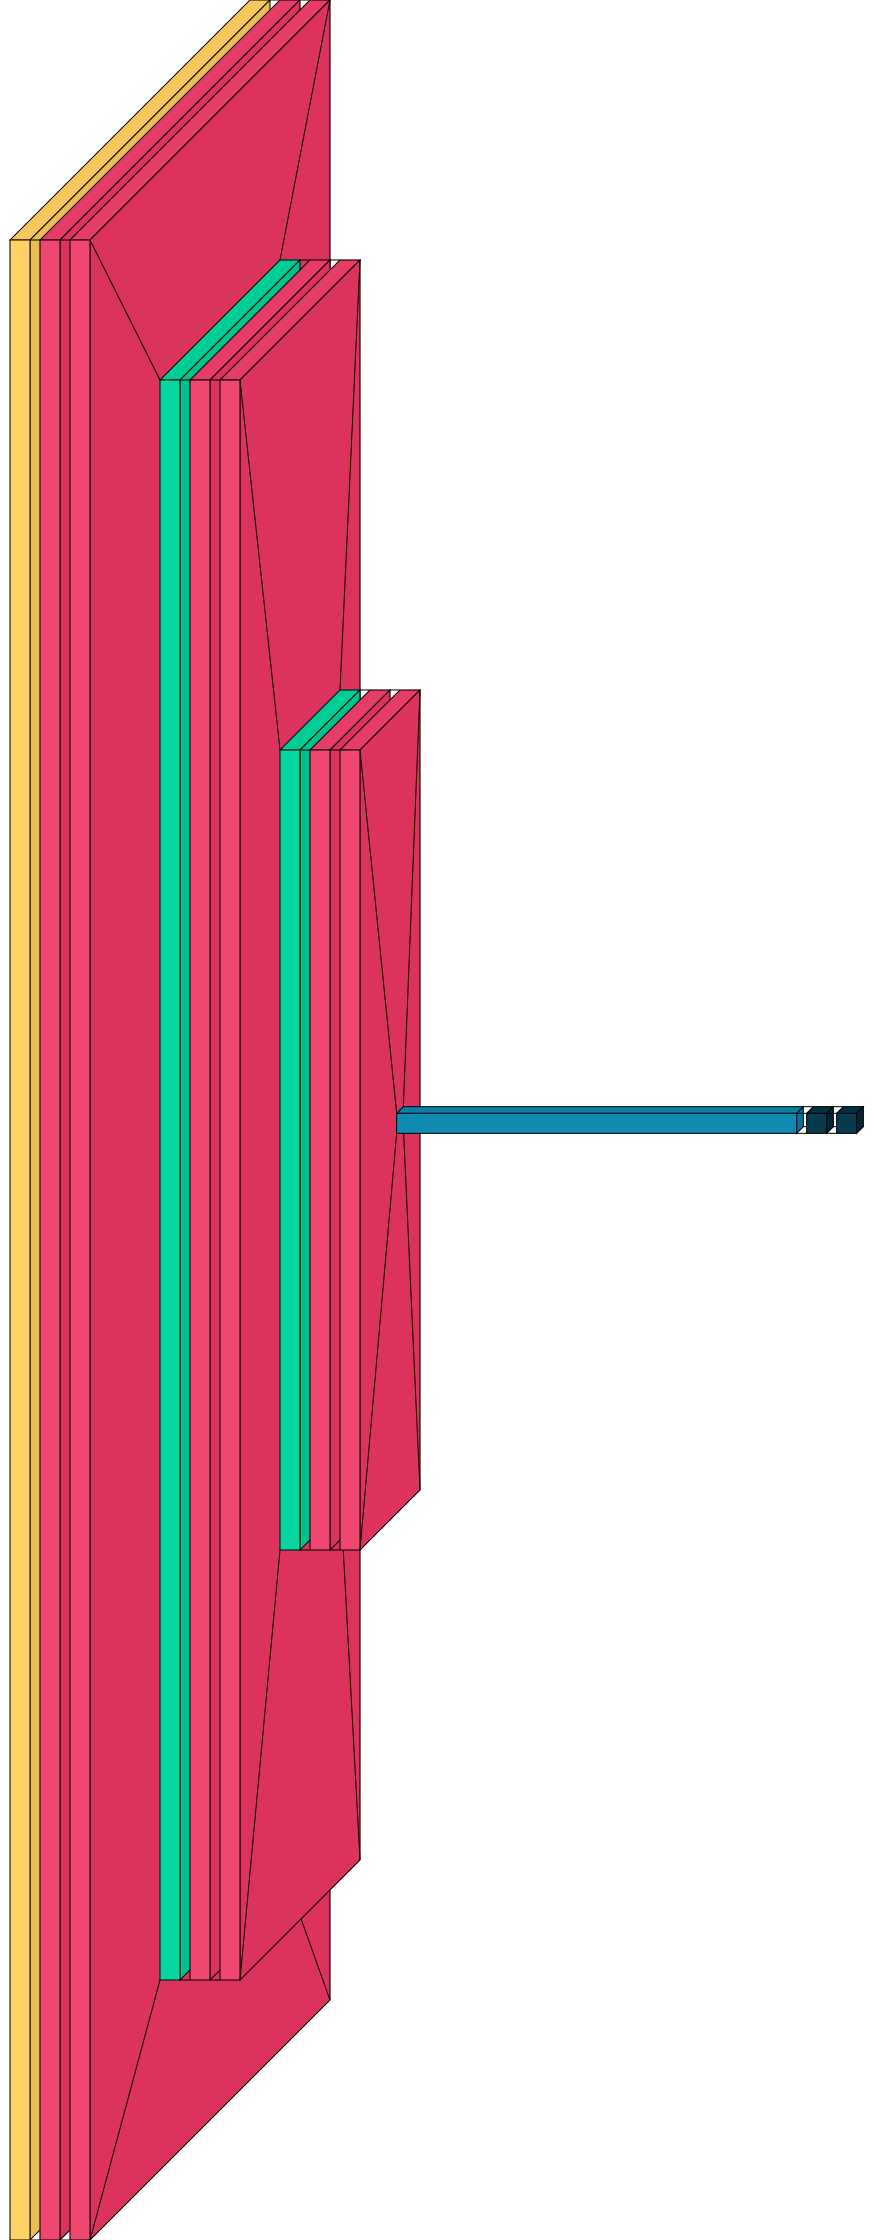

In [15]:
visualkeras.layered_view(model).show()

In [16]:
callbacks = [
    # EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.05, patience=15, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_CNN.h5', verbose=1, mode='max', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
]

In [17]:
results = model.fit(X_train, y_train, batch_size=64, epochs=10, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: -16.3632 - accuracy: 0.3488
Epoch 1: val_accuracy improved from -inf to 0.36364, saving model to model_CNN.h5
2/2 [==============================] - 36s 14s/step - loss: -16.3632 - accuracy: 0.3488 - val_loss: -248.6396 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: -396.2525 - accuracy: 0.3488
Epoch 2: val_accuracy did not improve from 0.36364
2/2 [==============================] - 1s 268ms/step - loss: -396.2525 - accuracy: 0.3488 - val_loss: -3112.0952 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: -4778.8320 - accuracy: 0.3488
Epoch 3: val_accuracy did not improve from 0.36364
2/2 [==============================] - 1s 269ms/step - loss: -4778.8320 - accuracy: 0.3488 - val_loss: -20575.5703 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: -26746.5352 - accur

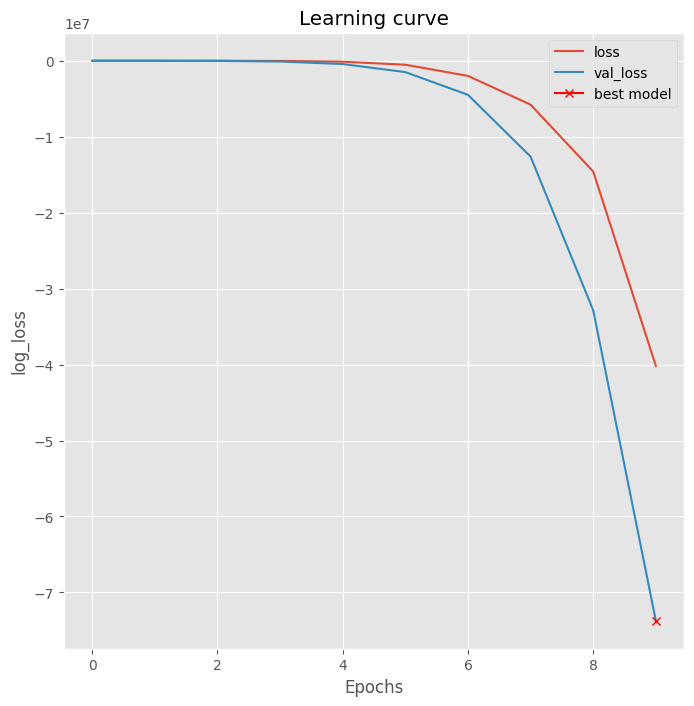

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

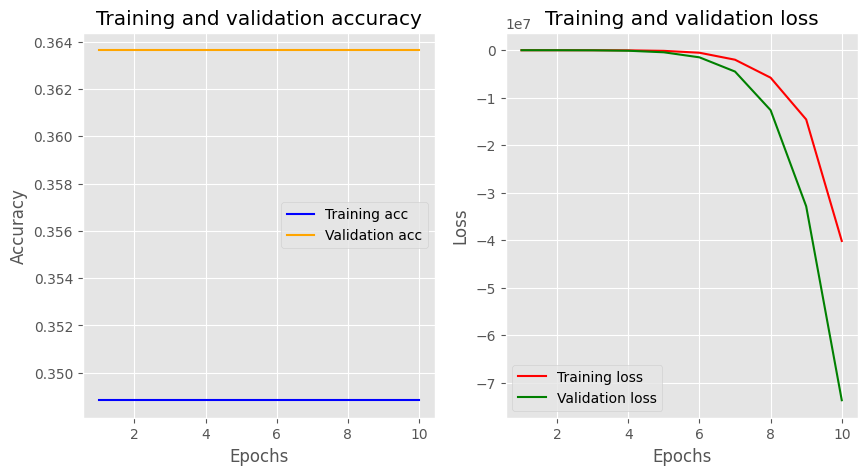

In [19]:
# accuracy and val loss of best model
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs_model = range(1, len(acc)+1) 

fig, axes = plt.subplots(1, 2,  figsize=(10,5))
axes[0].plot(epochs_model, acc, 'b', label = 'Training acc')
axes[0].plot(epochs_model, val_acc, 'orange', label = 'Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(epochs_model, loss, 'r', label = 'Training loss')
axes[1].plot(epochs_model, val_loss, 'g', label = 'Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')
plt.show()

In [20]:
# load the best model
model.load_weights('model_CNN.h5')
results = model.history

In [21]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# evaluate the model on the test data
loss, acc = model.evaluate(X_test, y_test)
val_loss, val_acc = model.evaluate(X_valid, y_valid)

print(f' train loss : {round(loss,4)} , train acc : {round(acc,4)}')
print(f' valid loss : {round(val_loss,4)} , valid acc : {round(val_acc,4)}')

1/1 [==============================] - 0s 45ms/step - loss: -248.6396 - accuracy: 0.3636
 train loss : -198.0673 , train acc : 0.3333
 valid loss : -248.6396 , valid acc : 0.3636


1/1 [==============================] - 0s 125ms/step


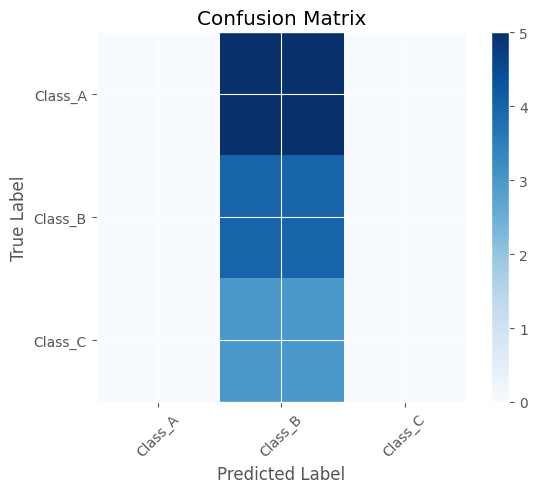

Confusion Matrix:
[[0 5 0]
 [0 4 0]
 [0 3 0]]


In [22]:
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(unique_df['Labels']))
plt.xticks(tick_marks, unique_df['Labels'], rotation=45)
plt.yticks(tick_marks, unique_df['Labels'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print("Confusion Matrix:")
print(cm)

In [25]:
# Calculate precision, recall, and F1 scores
report = classification_report(y_test, y_pred)

# Display the report
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.33      1.00      0.50         4
           2       0.00      0.00      0.00         3

    accuracy                           0.33        12
   macro avg       0.11      0.33      0.17        12
weighted avg       0.11      0.33      0.17        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
